In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from constants import CLASSES
from pathlib import Path
from utils import train_net

In [18]:
# for colab
# !wget -x --load-cookies cookies.txt "https://www.kaggle.com/deadskull7/fer2013/download" -O fer2013.zip
# !python unpack_data.py

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [21]:
trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

In [22]:
valset = torchvision.datasets.ImageFolder(root='./data/val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [23]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(16 * 9 * 9, 130)
        self.fc2 = nn.Linear(130, 40)
        self.fc3 = nn.Linear(40, 7)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = x.view(-1, 16 * 9 * 9)
        x = self.dropout(x)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
net = CustomNet()

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=3e-4, weight_decay=0.1)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, 3e-4, 1e-3, cycle_momentum=False)

[1,  2000] train_loss: 1.741, val_loss: 1.634, val_acc: 0.355
[1,  4000] train_loss: 1.590, val_loss: 1.498, val_acc: 0.412
[1,  6000] train_loss: 1.505, val_loss: 1.496, val_acc: 0.419
Finished training


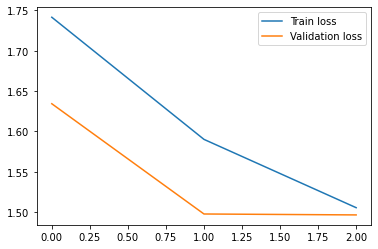

In [29]:
train_net(net, trainloader, valloader, criterion, optimizer, device, 
          num_epochs=10, lr_scheduler=scheduler)

In [11]:
Path('weights').mkdir(exist_ok=True)
PATH = 'weights/custom_net.pth'
torch.save(net.state_dict(), PATH)

### Evaluating

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
net = CustomNet()
net.load_state_dict(torch.load(PATH))
net.to(device)
net.eval()

CustomNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=130, bias=True)
  (fc2): Linear(in_features=130, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=7, bias=True)
)

In [14]:
testset = torchvision.datasets.ImageFolder(root='./data/test', transform=transform)
testloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 51 %
